<a href="https://colab.research.google.com/github/Jyok1m/cnn-image-project/blob/main/m2_JJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow Model 2

## Import dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- For this model, we decide to import the dataset via KaggleHub.
- The model will be saved locally.
- We then print and save the path in a dotenv file for data protection.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [3]:
DATASET_URI="/kaggle/input/animals10/raw-img"

In [ ]:
# from dotenv import dotenv_values

# # Retrieve dotenv config
# config = dotenv_values(".env")

# # Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [4]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras

### Data conversion

In [5]:
# Define the parameters.

random.seed(10)
batch_size = 42 # Increasing to 42 batch size
img_height = 224
img_width = 224
seed = random.randint(1, 200)
validation_split = 0.1 # Reducing to 10% val to

# We then import the dataset from directory and store the data in train and test.
# We follow a rule of 80% for training and 20% for testing.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [6]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (42, 224, 224, 3)
Shape of the training set labels => (42,)
Shape of the testing set images => (42, 224, 224, 3)
Shape of the testing set labels => (42,)


#### Pre-visualization

In [7]:
# Define train class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Print a summary of the image classes
print(f"Image classes ({num_classes} classes): ")
for class_name in class_names:
    print(class_name)

Image classes (10 classes): 
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo


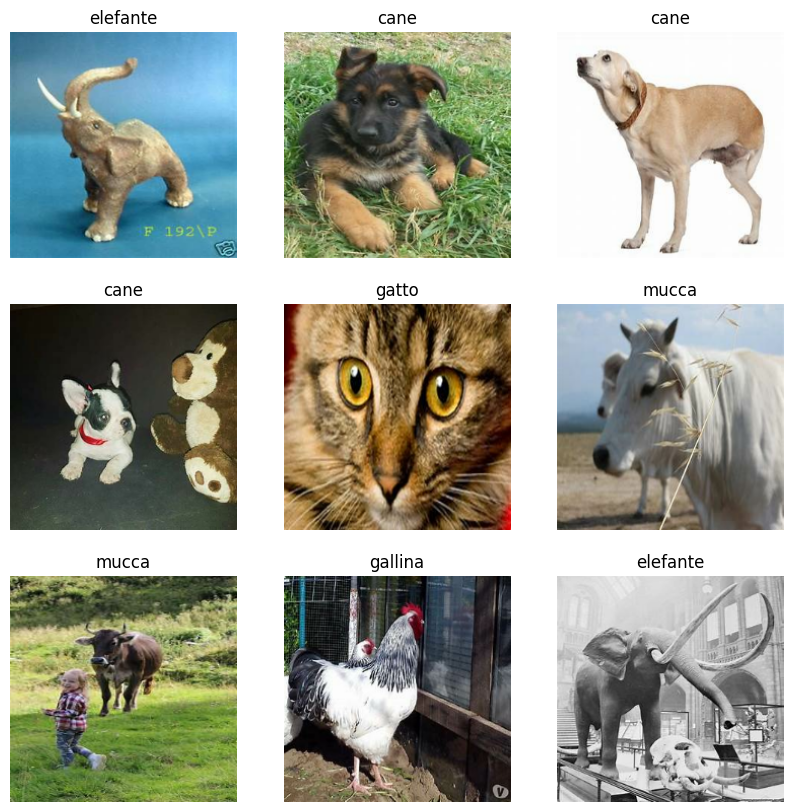

In [8]:
# Vizualise the images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


In [10]:
  # Model creation
  model_2 = keras.models.Sequential([
      keras.layers.Input(shape = (224, 224, 3)), # Input layer should be the first layer
      keras.layers.Rescaling(1./255),
      keras.layers.Conv2D(21, (3, 3), activation = "relu"),
      keras.layers.MaxPooling2D(2, 2),
      keras.layers.Conv2D(42, (3, 3), activation = "relu"),
      keras.layers.MaxPooling2D(2, 2),
      keras.layers.Conv2D(84, (3, 3), activation = "relu"),
      keras.layers.Dropout(0.2),
      # keras.layers.MaxPooling2D(2, 2),
      # keras.layers.Conv2D(168, (3, 3), activation = "relu"),
      # keras.layers.MaxPooling2D(2, 2),
      keras.layers.Flatten(),
      keras.layers.Dense(168, activation = "relu"),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(336, activation = "relu"),
      keras.layers.Dropout(0.2),
      # output Layer
      keras.layers.Dense(num_classes, activation = "softmax")

  ])

  # Print the model summary
  model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 21)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 21)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 42)   │         7,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 42)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 84)     │        31,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52, 52, 84)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 227136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 168)            │    38,159,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 336)            │        56,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         3,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,259,574 (145.95 MB)

 Trainable params: 38,259,574 (145.95 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Model compilation
model_2.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

# Model training
model_2_hist = model_2.fit(
  train_ds,
  validation_data = test_ds,
  batch_size=64,
  epochs=10
)

Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.2403 - loss: 2.1866 - val_accuracy: 0.4654 - val_loss: 1.5445
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.4601 - loss: 1.5502 - val_accuracy: 0.5449 - val_loss: 1.3281
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5848 - loss: 1.2173 - val_accuracy: 0.5701 - val_loss: 1.3073
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6938 - loss: 0.9000 - val_accuracy: 0.5625 - val_loss: 1.5055
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7868 - loss: 0.6356 - val_accuracy: 0.5716 - val_loss: 1.6309
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8483 - loss: 0.4562 - val_accuracy: 0.5686 - val_loss: 1.7653
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8799 - loss: 0.3587 - val_accuracy: 0.5655 - val_loss: 1.8308
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9133 - loss: 0.2674 - 

## Model evaluation

### Retrieve the keys

In [12]:
print(model_2_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

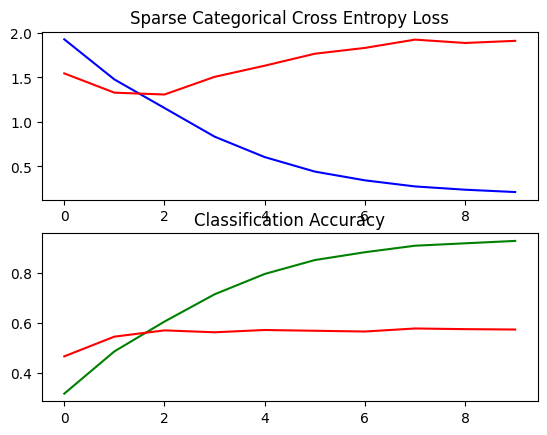

In [13]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(model_2_hist.history['loss'], color='blue', label='train')
plt.plot(model_2_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model_2_hist.history['accuracy'], color='green', label='train')
plt.plot(model_2_hist.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [14]:
test_loss, test_acc = model_2.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5801 - loss: 1.9688
Test loss =>  1.9101396799087524
Test accuracy =>  0.5735574960708618


### Print confusion matrix

In [15]:
import numpy as np
predictions = model_2.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
(2617, 10)
[[314  17  23   8  29  31  16  24  26  13]
 [ 26 144  28   2  13   3  26  11   9   4]
 [ 18  10  68   2   7   2  16  12  10   4]
 [ 11   4   0 152  11   4   1   3  22   5]
 [ 39   9   9  10 181   7   7  10  18  12]
 [ 48   2   1   9   3  42   1   4  24   8]
 [ 21  20  10   0  12   2  72  24   0   1]
 [ 27  16  12   2  12   6  24  83  18   5]
 [ 20   7   4  32  16   8   1   9 348  15]
 [ 32   7   6   2  12   8   1  16  36  97]]


Save the model

In [16]:
model_2.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/m2_JJ.keras")

# Start again


In [20]:
from tf.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras.regularizers import l2

# Test avec rotation image
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_ds)

# Model creation with better regularization and batch normalization
model_3 = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Rescaling(1./255),

    keras.layers.Conv2D(21, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(42, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(84, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(168, activation="relu", kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(336, activation="relu", kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation="softmax")
])

# Model compilation
model_3.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model training
model_3_hist = model_3.fit(
    datagen.flow(train_ds),
    validation_data=test_ds,
    batch_size=64,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

ModuleNotFoundError: No module named 'tf'